# Tutorial

## Tasks

Tasks are the basic unit of sflow. Each task encapsulates some unit of work. Tasks can be defined either through inheritance or using a decorator. For example, the following statements are (roughly) equivalent:

### Task through function decorator

In [1]:
import spype

@spype.task
def to_int(obj):
    return int(obj)

### Task through inheritance

In [2]:
class ToInt(spype.Task):
    
    def __init__(self):
        pass  # init some state when needed
        
    def __call__(self, obj):
        return int(obj)
    
to_int = ToInt()

Note: A call method must be defined.

Now calling the function, or an instance of the task class, will behave exactly like before. There is however, an added `run` method which will hook in all the spype machinery which includes optional type checking and callbacks. 

### Type checking
Tasks support run-time type checking using type hints. Defining a type hint will both validate data input to a task and ensure tasks are hooked together correctly (see [pypes](pype.ipynb)). They are completely optional, but I recommend you use them on real-world sflow applications to help you not screw up.

In [3]:
@spype.task
def str_to_int(obj: str) -> int:
    return int(obj)

try:
    str_to_int.run(1)
except TypeError:
    print('TypeError raised')

TypeError raised


Although spype's type system is not perfect, the use of most of the classes defined in the `typing` module, such as `Optional`, `Union`, `List`, etc. are supported.

In [4]:
from typing import Union, TypeVar, Optional


# -------------- using Optional, Union
@spype.task
def is_even(num: int) -> Optional[Union[bool, int]]:
    """ bad function to return True if even, else the number if odd.
    Return None if num == 13 """
    if num == 13:  # this will cause a type error
        return 'This is a mistake in the code'
    elif num % 2 == 0:
        return True
    else:
        return num
    
is_even(1)  # returns 1
is_even(2)  # returns True

# this raises TypeError as a str is not part of specified output
try:
    is_even.run(13)
except TypeError:
    print('TypeError raised')

TypeError raised


In [5]:
# ------------------ using typevar

TV = TypeVar('TV', int, float, str)

@spype.task
def add_to_self(obj: TV) -> TV:
    """ add an object to itself, return """
    if obj == 13:  # unlucky number, here is another bug
        return float(13 + 13)
    return obj + obj


# these are all good
add_to_self(10)  # returns 20
add_to_self('_java_sucks_')  # returns '_java_sucks__java_sucks_'
add_to_self(13.)  # returns 26.0 


# this raises because 13 is an int and 26.0 is a float (not the same type as input)
try:
    add_to_self.run(13)
except TypeError:
    print('TypeError raised')

TypeError raised


### Callbacks
Each task supports any number of one of four types of callbacks: 


| Callback | Description |
| :------: | :---------: |
| on_start | Called before running the task |
| on_failure | Called if the task raises an unhandled exception |
| on_success | Called if the task did not raise an unhandled exception |
| on_finish | Called when the task finishes, regardless of exceptions |


The callbacks can be defined using keywords in the decorator call or implemented as class methods. These are useful for customizing how failures are handled (e.g. dropping into a debugger), applying data validators, implementing hooks, etc.


####  Generic Callback Fixtures


Rather than requiring a specific signature for each type of callback, you can control the data the callbacks receive based on the argument names defined in the functions. This is known as a fixture (this concept was stolen from [pytest](https://docs.pytest.org/en/latest/)). 

spype.TASK_FIXTURES is a mapping that contains the supported task fixtures and a brief description of each:

In [6]:
spype.TASK_FIXTURES

mappingproxy({'args': 'A tuple of arguments passed to current task',
              'e': 'The exception object if one was raised, else None',
              'inputs': 'A tuple of (args, kwargs) passed as input to current task',
              'kwargs': 'A dict of keywork arguments passed to current task',
              'outputs': 'The outputs of calling a task, or None',
              'self': 'A reference to the current task object',
              'signature': "The signature of the task's run method",
              'task': 'A reference to the current task object'})

Here are a few simple examples of callbacks:

In [7]:
def on_failure(task, e, inputs):
    """ e is the exception raised, the inputs to the task are bound to args and kwargs """

def on_success(task, outputs):
    """ return values of the task are bound to args and kwargs """

Callbacks can be used with both class-based tasks and decorator tasks like so:

In [8]:
# attach callbacks in task class
class StrToInt(spype.Task):
    def __call__(self, obj: str) -> int:
        if obj == '13':
            raise ValueError('unlucky numbers not accepted')
        return int(obj)
    
    def on_failure(self, e, inputs):
        print(f'{self} raised: {e}\n')
        print(f'inputs are: {inputs}')


str_to_int = StrToInt()

str_to_int.run('13') # prints name and exception, then input args and kwargs. 

StrToInt instance raised: unlucky numbers not accepted

inputs are: (('13',), {})


In [9]:
# this is the equivelent function-based approach:

def on_failure(task, e, inputs):
        print(f'{task} raised {e}')
        print(f'input args: {inputs}')
    

@spype.task(on_failure=on_failure)
def str_to_int(obj: str) -> int:
    if obj == '13':
        raise ValueError('unlucky numbers not accepted')
    return None

str_to_int.run('13')

<function str_to_int at 0x7efe4c395d90> raised unlucky numbers not accepted
input args: (('13',), {})


#### Task Specific Callbacks

In addition to the task fixtures, callbacks can also request any of the named parameters in the task signature. However, if the task does not have the requested parameter this will raise an exception.

In [10]:
def on_start(a, c):
    print(f'on_start callback got a: {a}, c: {c}')

    
@spype.task(on_start=on_start)
def some_task(a, b, c):
    pass


some_task.run(1, 2, 3)

on_start callback got a: 1, c: 3


#### Replacing Task Output

If a callback returns any value other than `None`, the task will return that value. The value the callback returns will be output immediately without running the other callbacks.

In [11]:
def on_start(num1):
    return float(num1)
    
def on_finish():
    print('This line will never get printed')
    
@spype.task(on_start=on_start, on_finish=on_finish)
def return_float(num1) -> float:
    return num1

return_float.run(1)

1.0

#### Terminating Task Execution

If a task should stop execution, and return None (which will prevent any downstream processing carried out by pypes) `ExitTask` exception can be raised.

In [12]:
def stop_it():
    print('terminating task execution')
    raise spype.ExitTask
    
@spype.task(on_start=stop_it)
def some_task(a):
    return a

some_task.run(1)

terminating task execution


#### Replacing Callbacks

Callbacks can also be attached after task definition, or replace permanently or temporarily.

In [13]:
def dont_care(e):
    """ use this callback when you are beyond caring, maybe a friday afternoon? """
    print(f'just swallowed: "{e}"')


@spype.task
def naming_is_hard():
    raise ValueError('bad function call')


# You can also set callbacks default callbacks for all tasks using options
with spype.options(on_failure=dont_care):
    naming_is_hard.run()  # wont raise

just swallowed: "bad function call"


In [14]:
# callbacks can be overwritten, but don't do this unless you have a good reason
str_to_int.on_failure = dont_care  # replaces old callback (be careful with this one)

# you can also define a sequence of callbacks to be executed in order
str_to_int.on_failure = (dont_care, on_failure)  # calls dont_care first then on_failure

## Pypes

The `Pype` class is used to hook tasks together, and to controll data flow from task to task (yes, "pype" is a bad pun for "python pipes"). The basic idea; you can just hook tasks together in an intuitive way and use the resulting pype as a callable to kick the whole thing off. 

Some operators for hooking tasks/pypes together:

|Operator|Use|
|:--------|:------------:|
|&#124;|Hook tasks/pypes in series|
|&|Hook tasks/pypes in parallel|
|&#124;=|Hook tasks/pypes in serial in place| 
|&=|Hook task/pypes in parallel in place|
|<<|Fan outputs of tasks to next task|
|>>|Aggregate outputs of previous task|


Now let's look at some examples, but first let's define some stupid simple tasks: 

In [15]:
import spype
from spype import pype_input


@spype.task
def add_two(num: int) -> int:
    return num + 2


@spype.task
def raise_two(num: int) -> int:
    return num ** 2


@spype.task
def divide_two(num: int) -> int:
    return num // 2


@spype.task
def divide_numbers(num1: int, num2: int) -> int:
    return num1 // num2


@spype.task
def multiply_two(num: int) -> int:
    return num * 2


@spype.task
def split_str(some_str: str) -> str:
    return some_str.split()


@spype.task
def add_together(num1, num2):
    return num1 + num2


Tasks can be hooked together in series using the `|` operator, in which case the output of one task will be fed directly as the input to the next task.

In [16]:
pype = spype.pype_input | add_two | multiply_two | raise_two

### Pype Visualization
The plot function is used to visualize the relationships between tasks in a pype. You need [graphviz](https://www.graphviz.org/) and python package called [graphviz](https://github.com/xflr6/graphviz) installed on your system. 

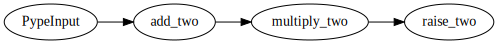

In [17]:
pype.plot()

Notice the pype starts with a special task called `PypeInput`. This will always be the case. 

### Print Pype Outputs
We can also turn on printing to better understand how data are flowing from task to task. To turn this feature on for the remainder of this python session this we will use spype.options. It can also be used as a context manager if you wanted to enable this feature temporarily (eg for debugging). 

In [18]:
spype.options(print_flow=True)
pype(2)

PypeInput got ((2,), {}) and returned (2,)
add_two got ((2,), {}) and returned 4
multiply_two got ((4,), {}) and returned 8
raise_two got ((8,), {}) and returned 64


64

Notice the structure of the data as it moves between tasks is (args, kwargs) where args is tuple of positional arguments and kwargs is a dict of named arguments. For example the input was ((2,), {}). This [SO question](https://stackoverflow.com/questions/3394835/args-and-kwargs) explains args and kwargs nicely if you are not familiar.

### Mixing pypes and tasks

We can also hook pypes together, or any combinations of pypes and tasks. 

PypeInput got ((0,), {}) and returned (0,)
add_two got ((0,), {}) and returned 2
multiply_two got ((2,), {}) and returned 4
raise_two got ((4,), {}) and returned 16


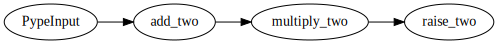

In [19]:
pype = spype.pype_input | add_two | multiply_two
pype |= raise_two  # modfies pype1 by attaching raise_two at the end
# pype1 and pype are equivelent
pype(0)
pype.plot()

### Hooking pypes in parallel

Pypes/tasks can be hooked in parallel using the `&` operator.

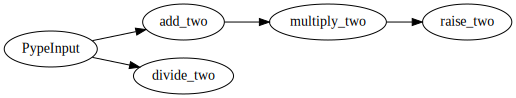

In [20]:
pype2 = pype & divide_two
pype2.plot()

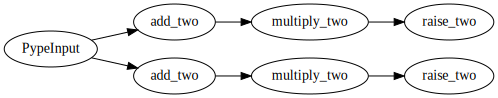

In [21]:
pype3 = pype & pype
pype3.plot()

### Broadcasting and Merging tasks
If you would like a pype/tasks output to be given as the input to several pypes/tasks (known as broadcasting), simply use a tuple. 

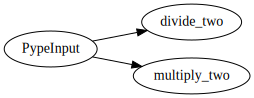

In [22]:
pype = spype.pype_input | (multiply_two, divide_two)
pype.plot()

Which results in the following execution:

In [23]:
pype(2)

PypeInput got ((2,), {}) and returned (2,)
multiply_two got ((2,), {}) and returned 4
divide_two got ((2,), {}) and returned 1


1

And the merging can also be done via a tuple

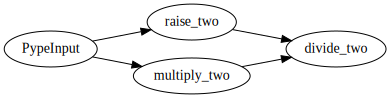

In [24]:
pype = spype.pype_input | (multiply_two, raise_two) | divide_two
pype.plot()

and the excution looks like this:

In [25]:
pype(2)

PypeInput got ((2,), {}) and returned (2,)
raise_two got ((2,), {}) and returned 4
divide_two got ((4,), {}) and returned 2
multiply_two got ((2,), {}) and returned 4
divide_two got ((4,), {}) and returned 2


2

Here is an unnecessarily complex example:

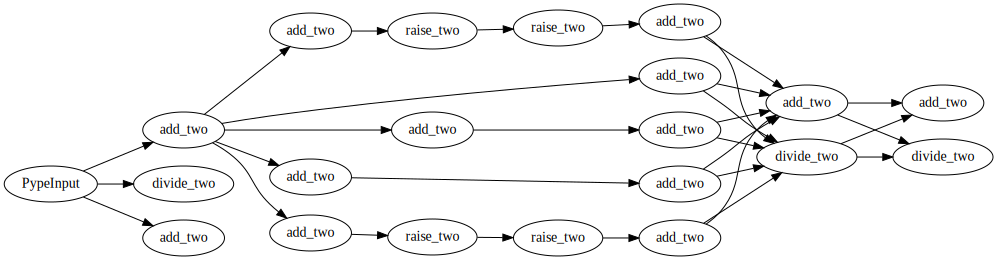

In [26]:
# define any pypes
p1 = spype.pype_input | add_two | raise_two | raise_two | add_two
p2 = spype.pype_input | add_two | add_two
# hook pypes to the end of add_two and feed outputs into divide_two
complex_pype = (spype.pype_input | add_two | (p1, p2, spype.pype_input | add_two, p2, p1) 
                | (divide_two, add_two) | (divide_two, add_two))
complex_pype &= (add_two, divide_two)
complex_pype.plot()

### Attaching tasks/pypes anywhere
In some cases it may be necessary to access a particular task directly when adding new tasks. This can be done using the get_item interface on a pype object. eg:

In [27]:
p1 = spype.pype_input | add_two | raise_two | divide_two

Now once this is defined it might be a bit tricky to attach something to the middle task but using the get_item interface makes it simple

PypeInput got ((2,), {}) and returned (2,)
add_two got ((2,), {}) and returned 4
raise_two got ((4,), {}) and returned 16
divide_two got ((16,), {}) and returned 8
multiply_two got ((4,), {}) and returned 8


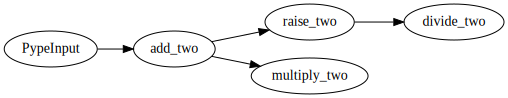

In [28]:
pype = p1[add_two] | multiply_two  
pype(2)
pype.plot()

### Getting intermediate values
If we want to see the last value a task returned we can use the get_item interface (square brackets) on the pypes's `outputs` attribute like so:

In [29]:
print(pype.outputs[raise_two])
print(pype.outputs[multiply_two])

((16,), {})
((8,), {})


If you want the given to the pype object when called, you can use `pype_input`

In [30]:
print(pype.outputs[spype.pype_input])

((2,), {})


__WARNING__: Accessing values in this way is mainly for debugging as this is not reliable when running multiple threads or processes. Also, tasks used as keys must be unique in the pype, see the gotchas section.

### Conditionals

If you want to trigger tasks only under certain conditions you can use the `iff` attribute of a task. `iff` takes a callable returns a single boolean. Like callbacks, you can use any of the fixtures or named arguments which are part of the task signature. For example:

In [31]:
def is_even(num):
    return (num % 2) == 0

pype = pype_input | add_two | multiply_two.iff(is_even) | raise_two

# if number is not even only add_two gets run
pype(3)

PypeInput got ((3,), {}) and returned (3,)
add_two got ((3,), {}) and returned 5
multiply_two got ((5,), {}) and returned None


5

Notice how execution occurred only through `multiply_two`, and stopped before `raise_two` when None was returned.

In [32]:
pype(2)  # if the number is even it will go all the way through

PypeInput got ((2,), {}) and returned (2,)
add_two got ((2,), {}) and returned 4
multiply_two got ((4,), {}) and returned 8
raise_two got ((8,), {}) and returned 64


64

Asking for an Spype fixtures also works

In [33]:
def print_pype(pype, task, wrap):
    print(f'called predicate with {(pype, task, wrap)}')
    return True

pype = pype_input | add_two.iff(print_pype)
pype(1)

PypeInput got ((1,), {}) and returned (1,)
called predicate with (Pype isntance

NODES: 

[PypeInput instance, <function add_two at 0x7efe4c354598>] 

 EDGES: 

[(PypeInput instance, <function add_two at 0x7efe4c354598>)] 

DEPENDENCIES:

 []
, <function add_two at 0x7efe4c354598>, task wrap of <function add_two at 0x7efe4c354598>)
add_two got ((1,), {}) and returned 3


3

### Fanning out

A single task may produce a sequence of objects, each of which need to be handled independently for the rest of the processing pypeline. Spype calls fanning out. It can be done using the `fan` attribute or by using the left bytes shift operator (<<, think of it as widening the outputs), although this can be a bit tricky due to byte shift occurring before the pype. 

An example:

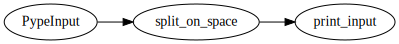

In [34]:
from typing import List

@spype.task
def split_on_space(obj: str) -> List[str]:
    """ yield the string split on spaces """
    return obj.split(' ')


@spype.task
def print_input(obj: str):
    print(f'just got {obj}')

# note the parentheses 
pype = (spype.pype_input | split_on_space) << print_input
pype.plot()

In [35]:
pype('szechuan sauce snafu')

PypeInput got (('szechuan sauce snafu',), {}) and returned ('szechuan sauce snafu',)
split_on_space got (('szechuan sauce snafu',), {}) and returned ['szechuan', 'sauce', 'snafu']
just got szechuan
print_input got (('szechuan',), {}) and returned None
just got sauce
print_input got (('sauce',), {}) and returned None
just got snafu
print_input got (('snafu',), {}) and returned None


['szechuan', 'sauce', 'snafu']

which is equivalent to 

In [36]:
pype = spype.pype_input | split_on_space | print_input.fan()
pype('szechuan sauce snafu')

PypeInput got (('szechuan sauce snafu',), {}) and returned ('szechuan sauce snafu',)
split_on_space got (('szechuan sauce snafu',), {}) and returned ['szechuan', 'sauce', 'snafu']
just got szechuan
print_input got (('szechuan',), {}) and returned None
just got sauce
print_input got (('sauce',), {}) and returned None
just got snafu
print_input got (('snafu',), {}) and returned None


['szechuan', 'sauce', 'snafu']

### Aggregating
Aggregate does the opposite of fanning out. It stores all the outputs of a task (until it is done executing) then sends them as a tuple to the downstream tasks. This can be activated using the `agg` attribute or the right byte shift operator (`>>` think of it as "funneling" outputs into a task). 

In [37]:
from typing import Tuple, TypeVar

tv = TypeVar('tv')

@spype.task
def join_str(obj: List[str]) -> str:
    return ' '.join(obj)


@spype.task
def pass_through(x: tv) -> tv:
    return x


pype = (spype.pype_input | split_on_space) << pass_through.agg() >> join_str | print_input
pype('a full string')

PypeInput got (('a full string',), {}) and returned ('a full string',)
split_on_space got (('a full string',), {}) and returned ['a', 'full', 'string']
pass_through got (('a',), {}) and returned a
pass_through got (('full',), {}) and returned full
pass_through got (('string',), {}) and returned string
join_str got ((['a', 'full', 'string'],), {}) and returned a full string
just got a full string
print_input got (('a full string',), {}) and returned None


'a full string'

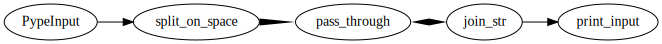

In [38]:
pype.plot()

### Dependency injection
If a task needs data that are not passed from the previous task you can use the `partial` method. For example, if the `num2` parameter in  the `divide_two` function should always be 2:

In [39]:
pype = spype.pype_input | add_two | raise_two | divide_numbers.partial(num2=2)

If the value of num2 depends on the output of another task, you can assign the task in the partial statement. Then, the value returned by the task will be assigned to the parameter.

In [40]:
pype = spype.pype_input | add_two | (raise_two, divide_numbers.partial(num1=raise_two))
pype(2) 

PypeInput got ((2,), {}) and returned (2,)
add_two got ((2,), {}) and returned 4
raise_two got ((4,), {}) and returned 16
divide_numbers got ((16, 4), {}) and returned 4


4

You can also define an argument's value using the set_item interface of the pype. Then, all unmet arguments with the same name used in the set_item call will be given that value or, the the value returned by a task if a task instance is used. For example:

In [41]:
pype = spype.pype_input | add_two | raise_two | divide_numbers
# if we called pype now it would raise because divide needs two arguments
# however, we can tell the pype what the value should be.
pype['num2'] = 2
# now 2 will automatically be passed to divide when no other value for num2 is found
pype(2)  # returns 8

PypeInput got ((2,), {}) and returned (2,)
add_two got ((2,), {}) and returned 4
raise_two got ((4,), {}) and returned 16
divide_numbers got ((16, 2), {}) and returned 8


8

In [42]:
pype = spype.pype_input | add_two | raise_two | divide_numbers
# we could also assign a task, indicating the output of the task should be used
pype['num2'] = add_two
pype(2)  # returns 4 because num2 = the result of add_two (4)

PypeInput got ((2,), {}) and returned (2,)
add_two got ((2,), {}) and returned 4
raise_two got ((4,), {}) and returned 16
divide_numbers got ((16, 4), {}) and returned 4


4

You need to be a little careful with this, if you define circular dependencies an InvalidPype exception will be raised the first time you try calling a malformed pype. 

### Debugging
Admittedly, it can be a bit challenging to navigate spype's working to get to debugging your tasks. For this reason, the pype Class has a `debug` method, which will essentially drop you into a debugger before each task or selected tasks get called.

In [43]:
pype = pype_input | multiply_two | raise_two

with pype.debug() as p:
    pass  # calling the pype will drop you into a debugger at the start of every task

### Gotchas

Spype still has a few warts which I hope to fix in the future. For now, there are mainly two things that might trip you up:

#### Task uniqueness
As demonstrated, tasks can be used as keys to set dependencies and check results. If a single task is used multiple times in a pype, however, some of these features will not be reliable, and will probably raise Exceptions in future versions.

For example, the following code will return the latest value returned by the `add_two` task.

In [44]:
pype = pype_input | add_two | add_two 
pype(2)
print(pype.outputs[add_two])

PypeInput got ((2,), {}) and returned (2,)
add_two got ((2,), {}) and returned 4
add_two got ((4,), {}) and returned 6
((6,), {})


If the pype was more complex, however, it would be difficult to know which `add_two` ouputs were being referred to.

In [45]:
pype = pype_input | (add_two, add_two, (pype_input | add_two | add_two))
pype &= add_two
pype(2)
print(pype.outputs[add_two])

PypeInput got ((2,), {}) and returned (2,)
add_two got ((2,), {}) and returned 4
add_two got ((2,), {}) and returned 4
add_two got ((2,), {}) and returned 4
add_two got ((4,), {}) and returned 6
add_two got ((2,), {}) and returned 4
((4,), {})


#### Task uniqueness: best practices 
There are a few  options for easily avoiding the issue if you do need to use a pype with multiple identical tasks (in order of preference):

1. Don't depend on features that require unique tasks
2. Use a class based task and instantiate different objects
3. Copy tasks using the copy function

The last option will probably break the ability of the pickle module to serialize the pype. 

##### option 1
Most of the pype features will work fine, so if you can rethink how the pype is being used to avoid needing any of the tasks to be unique it is probably the most prudent course of action.

##### option 2
Instances of class based tasks will work as expected:

In [46]:
class AddTwo(spype.Task):
    def __call__(self, num: int) -> int:
        return num + 2
    
add2 = [AddTwo() for _ in range(3)]

pype = pype_input | add2[0] | add2[1] | add2[2]
pype(2)

for add in add2:
    print(pype.outputs[add])

PypeInput got ((2,), {}) and returned (2,)
AddTwo got ((2,), {}) and returned 4
AddTwo got ((4,), {}) and returned 6
AddTwo got ((6,), {}) and returned 8
((4,), {})
((6,), {})
((8,), {})


##### option 3
You can also simply copy a task using the `copy` method, though the resulting task will probably not be serializable using vanilla pickle so it may mess up multiprocessing.

In [47]:
add2 = add_two.copy(), add_two.copy(), add_two.copy()

pype = pype_input | add2[0] | add2[1] | add2[2]
pype(2)

for add in add2:
    print(pype.outputs[add])

PypeInput got ((2,), {}) and returned (2,)
add_two got ((2,), {}) and returned 4
add_two got ((4,), {}) and returned 6
add_two got ((6,), {}) and returned 8
((4,), {})
((6,), {})
((8,), {})
